<a href="https://colab.research.google.com/github/RajXcoder-web/UNET_Brain_segmentation/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scikit-image scikit-learn opencv-python tqdm h5py


In [4]:
import os
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.measure import perimeter, label, regionprops
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, Model


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
DATA_ROOT = "/content/drive/MyDrive/BMD"


In [7]:
mat_files = []

for root, dirs, files in os.walk(DATA_ROOT):
    for f in files:
        if f.endswith(".mat") and f != "cvind.mat":
            mat_files.append(os.path.join(root, f))

mat_files = sorted(mat_files)
print("Total .mat files found:", len(mat_files))


Total .mat files found: 3064


In [8]:
def load_mat_v73(path):
    with h5py.File(path, 'r') as f:
        cj = f['cjdata']

        img = np.array(cj['image']).astype(np.float32)
        mask = np.array(cj['tumorMask']).astype(np.uint8)
        border = np.array(cj['tumorBorder']).flatten().astype(np.float32)
        label = int(np.array(cj['label'])[0][0])  # 1,2,3

        return img, mask, border, label


In [9]:
images = []
masks = []
borders = []
labels = []

for path in tqdm(mat_files):
    img, mask, border, label = load_mat_v73(path)

    images.append(img)
    masks.append(mask)
    borders.append(border)
    labels.append(label - 1)   # convert 1,2,3 → 0,1,2


100%|██████████| 3064/3064 [27:41<00:00,  1.84it/s]


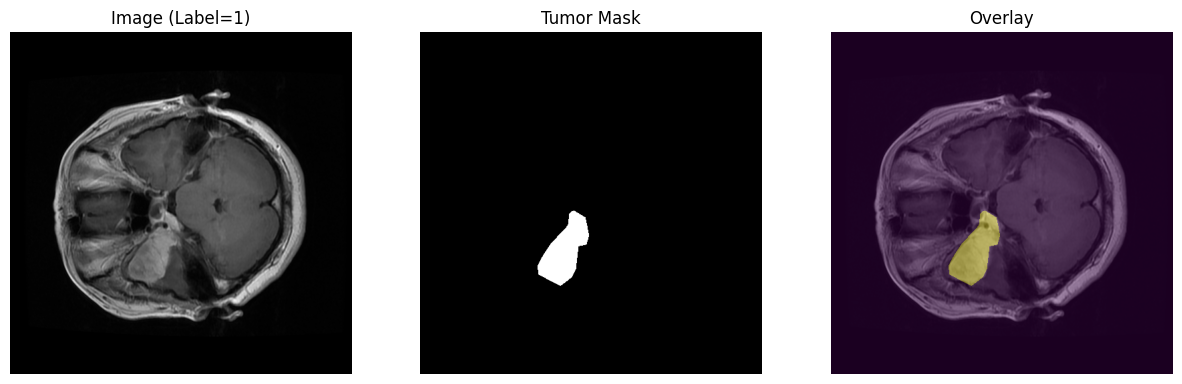

In [10]:
idx = 0

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(images[idx], cmap='gray')
plt.title(f"Image (Label={labels[idx]+1})")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(masks[idx], cmap='gray')
plt.title("Tumor Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(images[idx], cmap='gray')
plt.imshow(masks[idx], alpha=0.4)
plt.title("Overlay")
plt.axis('off')

plt.show()


In [11]:
def border_to_mask(border, size):
    pts = border.reshape(-1,2).astype(np.int32)
    mask = np.zeros(size, dtype=np.uint8)
    if len(pts) > 0:
        cv2.fillPoly(mask, [pts], 1)
    return mask

border_masks = [border_to_mask(b, img.shape) for b, img in zip(borders, images)]


In [13]:
import math
from skimage.measure import label as sklabel

def fractal_dimension(mask):
    sizes = [2,4,8,16,32,64]
    counts = []
    for s in sizes:
        resized = cv2.resize(mask.astype(np.uint8), (s, s), interpolation=cv2.INTER_NEAREST)
        counts.append(np.count_nonzero(resized))
    sizes = np.array(sizes) + 1e-6
    counts = np.array(counts) + 1e-6
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

shape_features = []

for m in border_masks:
    mb = (m > 0).astype(np.uint8)
    lbl = sklabel(mb)

    if lbl.max() == 0:
        shape_features.append([0]*6)
        continue

    props = regionprops(lbl)[0]

    area = props.area
    per = perimeter(mb)

    roundness = 4 * math.pi * area / (per**2 + 1e-6)
    irregularity = per / (2 * math.sqrt(math.pi * area + 1e-6))

    points = np.column_stack(np.nonzero(mb))
    if len(points) >= 3:
        hull = ConvexHull(points)
        hull_area = hull.volume
    else:
        hull_area = area

    convex_ratio = area / (hull_area + 1e-6)
    fract = fractal_dimension(mb)

    shape_features.append([
        area, per, roundness, irregularity, convex_ratio, fract
    ])

shape_features = np.array(shape_features, dtype=np.float32)
shape_features.shape


(3064, 6)

In [14]:
scaler = StandardScaler()
shape_scaled = scaler.fit_transform(shape_features)


In [15]:
IMG_SIZE = 128

X_img = []
for img in images:
    img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img_resized = cv2.resize(img_norm, (IMG_SIZE, IMG_SIZE))
    X_img.append(img_resized)

X_img = np.array(X_img, dtype=np.float32) / 255.0
X_img = X_img[..., np.newaxis]

y = np.array(labels)


In [16]:
def build_cnn():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(inp, x)

cnn_branch = build_cnn()
cnn_branch.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,184 (426.50 KB)

 Trainable params: 109,184 (426.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
shape_inp = layers.Input(shape=(shape_scaled.shape[1],))
s = layers.Dense(64, activation='relu')(shape_inp)
s = layers.Dense(32, activation='relu')(s)
shape_branch = Model(shape_inp, s)
shape_branch.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,528 (9.88 KB)

 Trainable params: 2,528 (9.88 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
combined = layers.concatenate([cnn_branch.output, shape_branch.output])
x = layers.Dense(64, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
out = layers.Dense(3, activation='softmax')(x)

fusion_model = Model(inputs=[cnn_branch.input, shape_branch.input], outputs=out)

fusion_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        448 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        195 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,211 (477.39 KB)

 Trainable params: 122,211 (477.39 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from sklearn.model_selection import train_test_split

X_train_img, X_test_img, X_train_shape, X_test_shape, y_train, y_test = train_test_split(
    X_img, shape_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [21]:
history_fusion = fusion_model.fit(
    [X_train_img, X_train_shape], y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.5324 - loss: 0.9997 - val_accuracy: 0.6925 - val_loss: 0.7140
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6727 - loss: 0.7323 - val_accuracy: 0.7332 - val_loss: 0.6258
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7125 - loss: 0.6469 - val_accuracy: 0.7434 - val_loss: 0.6019
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7223 - loss: 0.6262 - val_accuracy: 0.7434 - val_loss: 0.5892
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7159 - loss: 0.6317 - val_accuracy: 0.7699 - val_loss: 0.5279
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7617 - loss: 0.5573 - val_accuracy: 0.7637 - val_loss: 0.4916
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7613 - loss: 0.5414 - val_accuracy: 0.8086 - val_loss: 0.4599
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7904 - loss: 0.4878 - val_accuracy: 0.7760 -

In [22]:
test_loss, test_acc = fusion_model.evaluate([X_test_img, X_test_shape], y_test)
print("Fusion Model Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8409 - loss: 0.4252
Fusion Model Accuracy: 0.8303425908088684


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


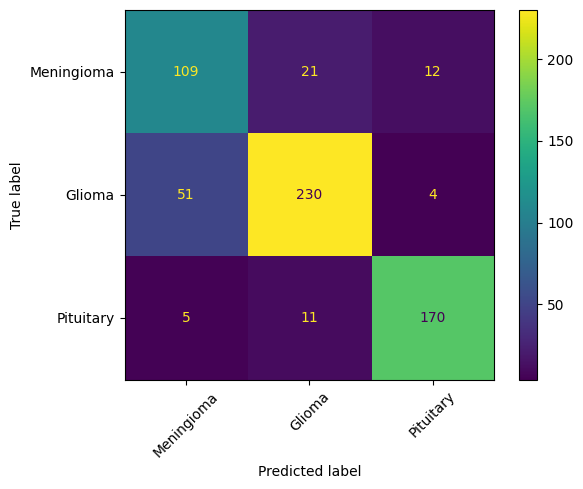

In [23]:
y_pred = np.argmax(fusion_model.predict([X_test_img, X_test_shape]), axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Meningioma", "Glioma", "Pituitary"])
disp.plot(xticks_rotation=45)
plt.show()


In [24]:
inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = cnn_branch(inp)
out = layers.Dense(3, activation='softmax')(x)

baseline_model = Model(inp, out)
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_base = baseline_model.fit(
    X_train_img, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6916 - loss: 0.7872 - val_accuracy: 0.7658 - val_loss: 0.5437
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7663 - loss: 0.5753 - val_accuracy: 0.7984 - val_loss: 0.5156
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7559 - loss: 0.5482 - val_accuracy: 0.8208 - val_loss: 0.4332
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7928 - loss: 0.4992 - val_accuracy: 0.8452 - val_loss: 0.3981
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7977 - loss: 0.5095 - val_accuracy: 0.8228 - val_loss: 0.3908
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7845 - loss: 0.4931 - val_accuracy: 0.8228 - val_loss: 0.3757
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7833 - loss: 0.4776 - val_accuracy: 0.8024 - val_loss: 0.3969
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8070 - loss: 0.4593 - val_accuracy: 0.8493 - 

In [25]:
_, base_acc = baseline_model.evaluate(X_test_img, y_test)
print("Baseline Accuracy:", base_acc)
print("Fusion Improvement:", test_acc - base_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8043 - loss: 0.4349
Baseline Accuracy: 0.8009787797927856
Fusion Improvement: 0.029363811016082764


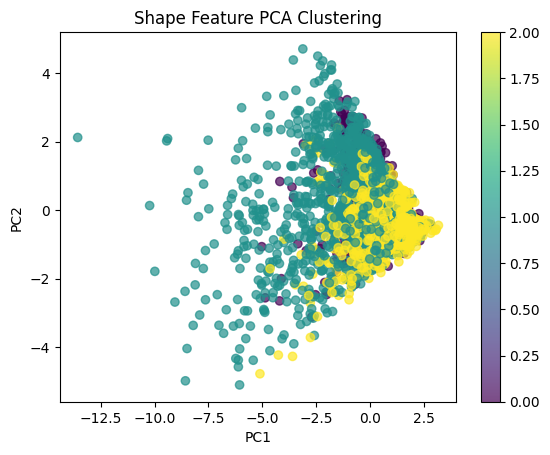

In [26]:
pca = PCA(n_components=2).fit_transform(shape_scaled)

plt.scatter(pca[:,0], pca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.title("Shape Feature PCA Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()


In [27]:
test_loss, test_acc = fusion_model.evaluate([X_test_img, X_test_shape], y_test)
print("Fusion model – test accuracy:", test_acc)
print("Fusion model – test loss:", test_loss)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7160 - loss: 0.6760
Fusion model – test accuracy: 0.7112561464309692
Fusion model – test loss: 0.679901123046875


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True label:      Pituitary
Predicted label: Pituitary
Class probs:     [5.1528312e-02 1.6476942e-04 9.4830692e-01]


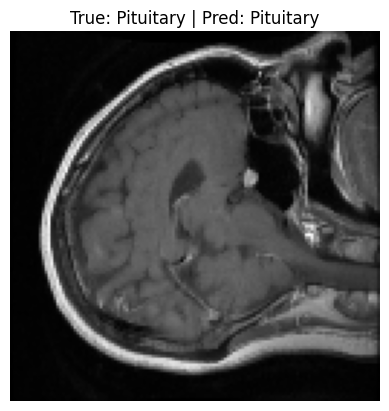

In [28]:
import random

class_names = ["Meningioma", "Glioma", "Pituitary"]

# pick a random index from test set
i = random.randint(0, len(X_test_img) - 1)

x_img = X_test_img[i:i+1]          # shape (1, H, W, 1)
x_shape = X_test_shape[i:i+1]      # shape (1, 6)
true_label = y_test[i]

# predict
pred_prob = fusion_model.predict([x_img, x_shape])
pred_label = np.argmax(pred_prob, axis=1)[0]

print("True label:     ", class_names[true_label])
print("Predicted label:", class_names[pred_label])
print("Class probs:    ", pred_prob[0])

# show the image
plt.imshow(X_test_img[i].squeeze(), cmap='gray')
plt.title(f"True: {class_names[true_label]} | Pred: {class_names[pred_label]}")
plt.axis('off')
plt.show()


In [30]:
def prepare_single_case(mat_path):
    # 1. load data
    img, mask, border, label = load_mat_v73(mat_path)

    # 2. build border mask (same as training)
    bm = border_to_mask(border, img.shape)

    # 3. compute shape features
    mb = (bm > 0).astype(np.uint8)
    lbl_img = sklabel(mb)

    if lbl_img.max() == 0:
        feats = np.zeros(6, dtype=np.float32)
    else:
        props = regionprops(lbl_img)[0]
        area = props.area
        per = perimeter(mb)

        roundness = 4 * math.pi * area / (per**2 + 1e-6)
        irregularity = per / (2 * np.sqrt(math.pi * area + 1e-6))

        points = np.column_stack(np.nonzero(mb))
        if len(points) >= 3:
            hull = ConvexHull(points)
            hull_area = hull.volume
        else:
            hull_area = area

        convex_ratio = area / (hull_area + 1e-6)
        fract = fractal_dimension(mb)

        feats = np.array([area, per, roundness, irregularity, convex_ratio, fract],
                         dtype=np.float32)

    # 4. scale shape features using the SAME scaler
    feats_scaled = scaler.transform(feats.reshape(1, -1))

    # 5. preprocess image (normalize + resize)
    img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img_resized = cv2.resize(img_norm, (IMG_SIZE, IMG_SIZE))
    img_resized = img_resized.astype(np.float32) / 255.0
    img_resized = img_resized[np.newaxis, ..., np.newaxis]  # (1,H,W,1)

    return img_resized, feats_scaled, label - 1  # return 0/1/2 label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Testing file: /content/drive/MyDrive/BMD/brainTumorDataPublic_1-766/100.mat
True label:      Meningioma
Predicted label: Meningioma
Probabilities:   [0.84578276 0.0685499  0.08566727]


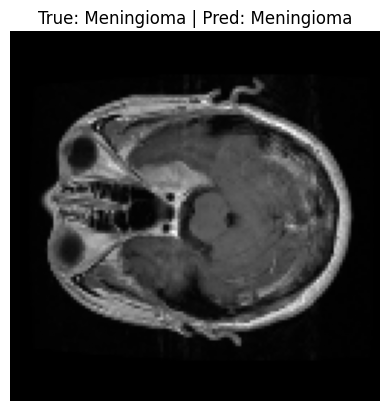

In [31]:
class_names = ["Meningioma", "Glioma", "Pituitary"]

test_path = "/content/drive/MyDrive/BMD/brainTumorDataPublic_1-766/100.mat"  # change index if you like

x_img_single, x_shape_single, true_label_single = prepare_single_case(test_path)

pred_prob = fusion_model.predict([x_img_single, x_shape_single])
pred_label_single = np.argmax(pred_prob, axis=1)[0]

print("Testing file:", test_path)
print("True label:     ", class_names[true_label_single])
print("Predicted label:", class_names[pred_label_single])
print("Probabilities:  ", pred_prob[0])

plt.imshow(x_img_single[0].squeeze(), cmap='gray')
plt.title(f"True: {class_names[true_label_single]} | Pred: {class_names[pred_label_single]}")
plt.axis('off')
plt.show()


In [32]:
fusion_model.save("/content/drive/MyDrive/BMD/fusion_model.h5")
print("Fusion model saved.")


Fusion model saved.


In [33]:
import joblib
joblib.dump(scaler, "/content/drive/MyDrive/BMD/shape_scaler.pkl")
print("Scaler saved.")


Scaler saved.


In [34]:
baseline_model.save("/content/drive/MyDrive/BMD/baseline_cnn_model.h5")
print("Baseline model saved.")


Baseline model saved.
